In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [2]:
# Load the dataset
df = pd.read_csv("../data/togo-dapaong_qc.csv")

# Preview
df.head()


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,...,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,diff_min,outlier_flag
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,...,227.6,1.1,977,0,0.0,24.7,24.4,NaN,NaN,False
1,2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,...,229.3,0.7,977,0,0.0,24.7,24.4,NaN,1.0,False
2,2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,...,228.5,2.9,977,0,0.0,24.7,24.4,NaN,1.0,False
3,2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,...,229.1,4.6,977,0,0.0,24.7,24.4,NaN,1.0,False
4,2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,...,227.5,1.6,977,0,0.0,24.7,24.4,NaN,1.0,False


In [3]:
print("Rows, Columns:", df.shape)
df.info()


Rows, Columns: (516349, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516349 entries, 0 to 516348
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      516349 non-null  object 
 1   GHI            516349 non-null  float64
 2   DNI            516349 non-null  float64
 3   DHI            516349 non-null  float64
 4   ModA           516349 non-null  float64
 5   ModB           516349 non-null  float64
 6   Tamb           516349 non-null  float64
 7   RH             516349 non-null  float64
 8   WS             516349 non-null  float64
 9   WSgust         516349 non-null  float64
 10  WSstdev        516349 non-null  float64
 11  WD             516349 non-null  float64
 12  WDstdev        516349 non-null  float64
 13  BP             516349 non-null  int64  
 14  Cleaning       516349 non-null  int64  
 15  Precipitation  516349 non-null  float64
 16  TModA          516349 non-null  float64
 17  T

In [4]:
# Summary of numeric columns
df.describe()

# Missing-value report
missing_report = df.isna().sum()
missing_report = missing_report[missing_report > 0]
missing_report


Comments    516349
diff_min         1
dtype: int64

In [5]:
# Columns to check
numeric_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores
z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy='omit'))
outliers = (z_scores > 3)
outlier_counts = np.sum(outliers, axis=0)

print("Outlier count per feature:")
print(dict(zip(numeric_cols, outlier_counts)))


Outlier count per feature:
{'GHI': np.int64(127), 'DNI': np.int64(386), 'DHI': np.int64(1422), 'ModA': np.int64(10), 'ModB': np.int64(66), 'WS': np.int64(944), 'WSgust': np.int64(638)}


In [7]:
# Fill missing numeric columns with median
df_clean = df.copy()
df_clean[numeric_cols] = df_clean[numeric_cols].apply(lambda x: x.fillna(x.median()))


In [15]:
df_clean.to_csv("../data/togo_clean.csv", index=False)
print("✅ Cleaned data saved (not to be committed to Git).")

✅ Cleaned data saved (not to be committed to Git).


In [16]:
# Assuming your cleaned DataFrame for this country is named 'df_clean'
# 1. Calculate average ModA for clean and dirty states
# Group by the 'Cleaning' flag (0: Dirty/No Clean, 1: Clean/Post Clean) and get the mean ModA.
soiling_summary = df_clean.groupby('Cleaning')['ModA'].mean()

# 2. Check if both states (0 and 1) exist before proceeding
if 0 in soiling_summary.index and 1 in soiling_summary.index:
    modA_dirty_mean = soiling_summary.loc[0] # Cleaning=0 (Dirty)
    modA_clean_mean = soiling_summary.loc[1] # Cleaning=1 (Clean)

    # 3. Calculate percentage soiling loss
    # Loss = (Clean Mean - Dirty Mean) / Clean Mean * 100
    soiling_loss_percent = ((modA_clean_mean - modA_dirty_mean) / modA_clean_mean) * 100

    print("--- Soiling Loss Analysis ---")
    print(f"Average ModA (Dirty/No Cleaning): {modA_dirty_mean:.2f} W/m²")
    print(f"Average ModA (Clean/Post Cleaning): {modA_clean_mean:.2f} W/m²")
    print(f"Estimated Soiling Loss: {soiling_loss_percent:.2f}%")
else:
    print("WARNING: Insufficient data to calculate soiling loss. Both Cleaning=0 and Cleaning=1 events must be present.")

# Save the estimated soiling loss percentage for your final report!

--- Soiling Loss Analysis ---
Average ModA (Dirty/No Cleaning): 219.22 W/m²
Average ModA (Clean/Post Cleaning): 528.86 W/m²
Estimated Soiling Loss: 58.55%


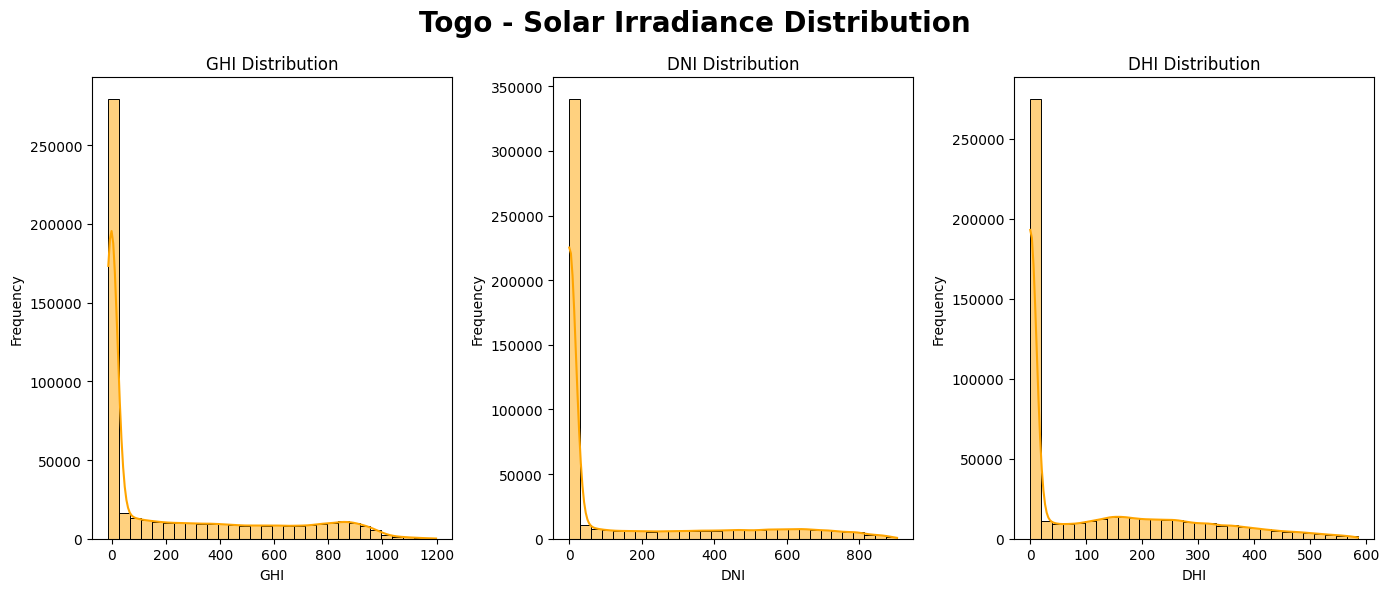

In [8]:
solar_features = ['GHI', 'DNI', 'DHI']

plt.figure(figsize=(14, 6))
for i, feature in enumerate(solar_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_clean[feature], kde=True, bins=30, color='orange')
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.suptitle('Togo - Solar Irradiance Distribution', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()


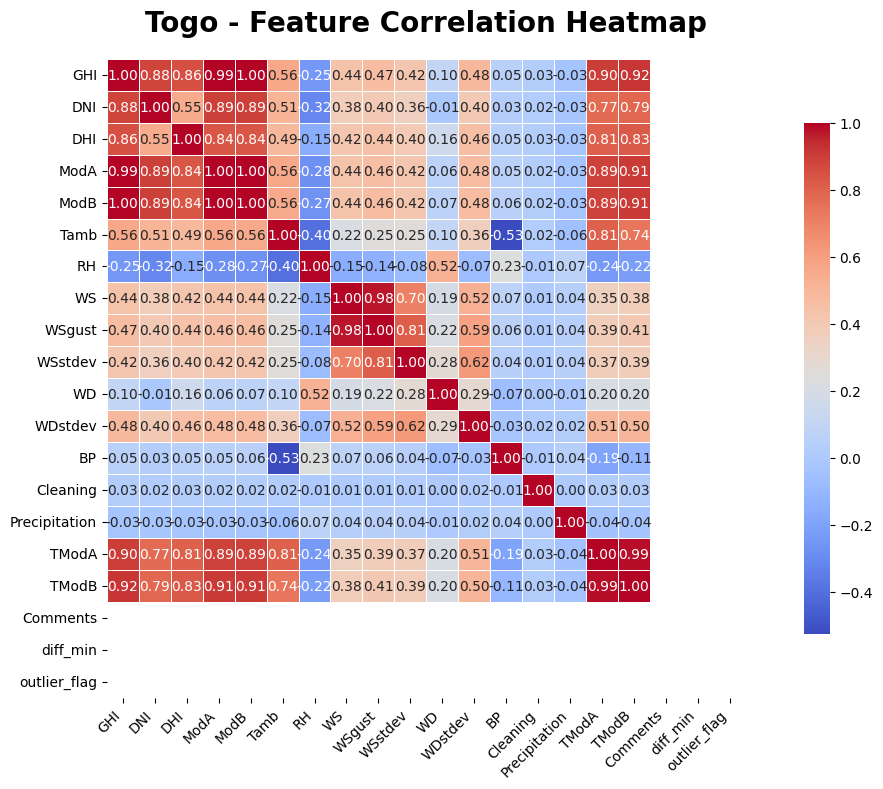

In [9]:
plt.figure(figsize=(12, 8))
corr = df_clean.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            linewidths=0.5, cbar_kws={'shrink': 0.8}, square=True)
plt.title("Togo - Feature Correlation Heatmap", fontsize=20, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_13892\1219139198.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\hp\Desktop\Kifya\solar-challenge-week0\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


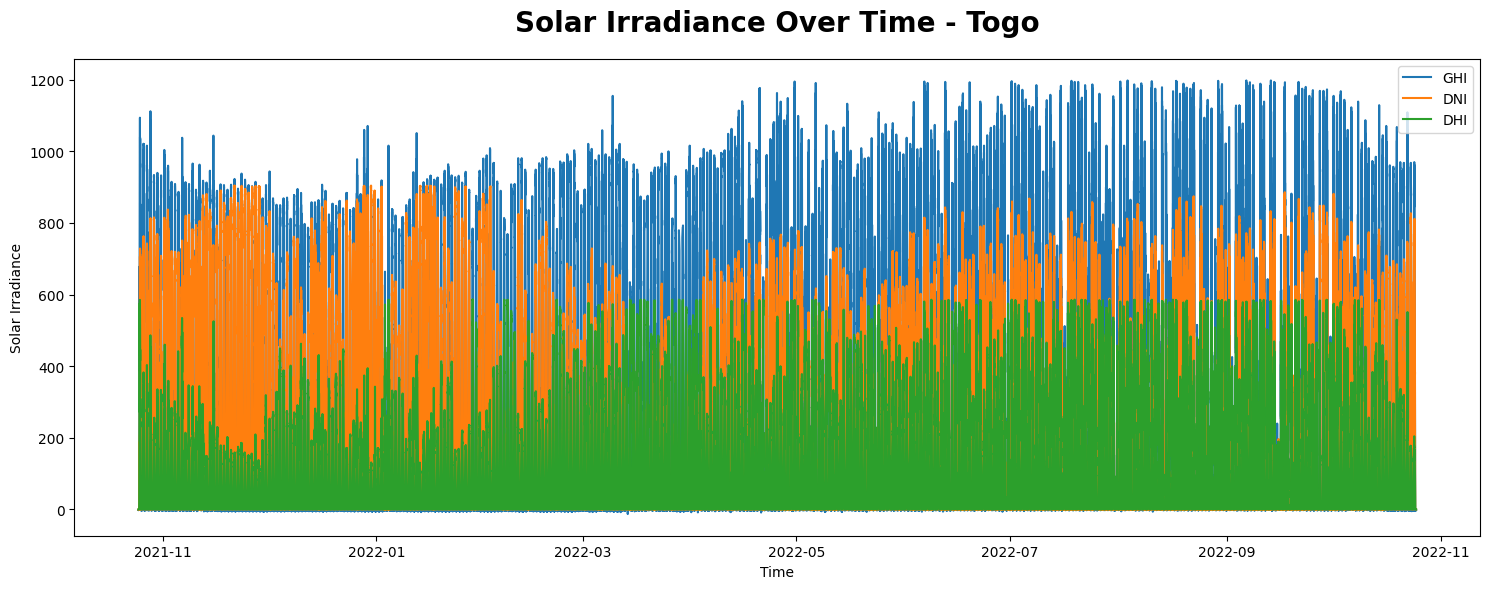

In [10]:
# Convert timestamp to datetime if not already
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')

plt.figure(figsize=(15, 6))
plt.plot(df_clean['Timestamp'], df_clean['GHI'], label='GHI')
plt.plot(df_clean['Timestamp'], df_clean['DNI'], label='DNI')
plt.plot(df_clean['Timestamp'], df_clean['DHI'], label='DHI')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance')
plt.title('Solar Irradiance Over Time - Togo' , fontsize=20, fontweight='bold', pad=20)
plt.legend()
plt.tight_layout()
plt.show()


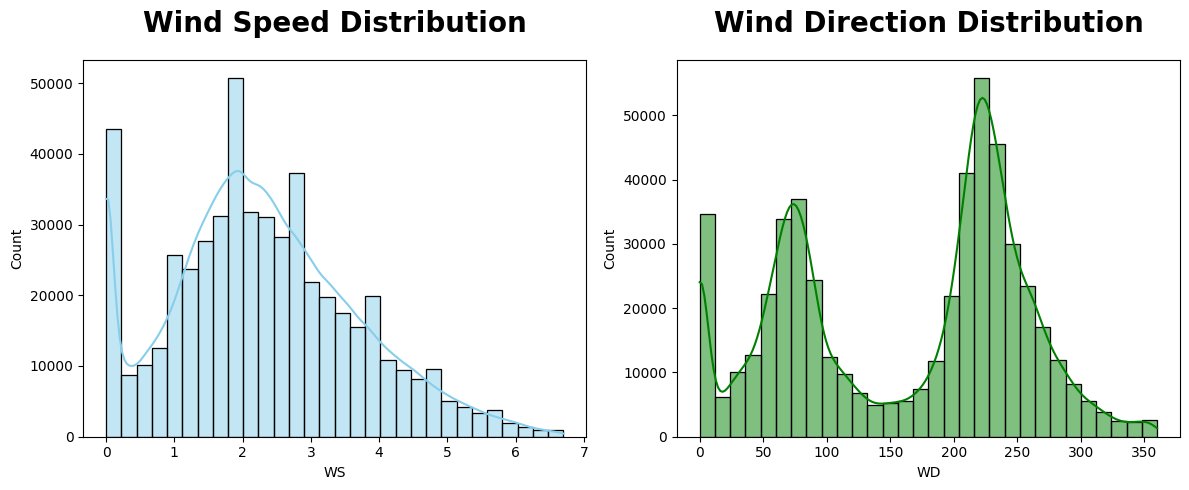

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df_clean['WS'], kde=True, bins=30, color='skyblue')
plt.title('Wind Speed Distribution' , fontsize=20, fontweight='bold', pad=20)

plt.subplot(1,2,2)
sns.histplot(df_clean['WD'], kde=True, bins=30, color='green')
plt.title('Wind Direction Distribution'  , fontsize=20, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


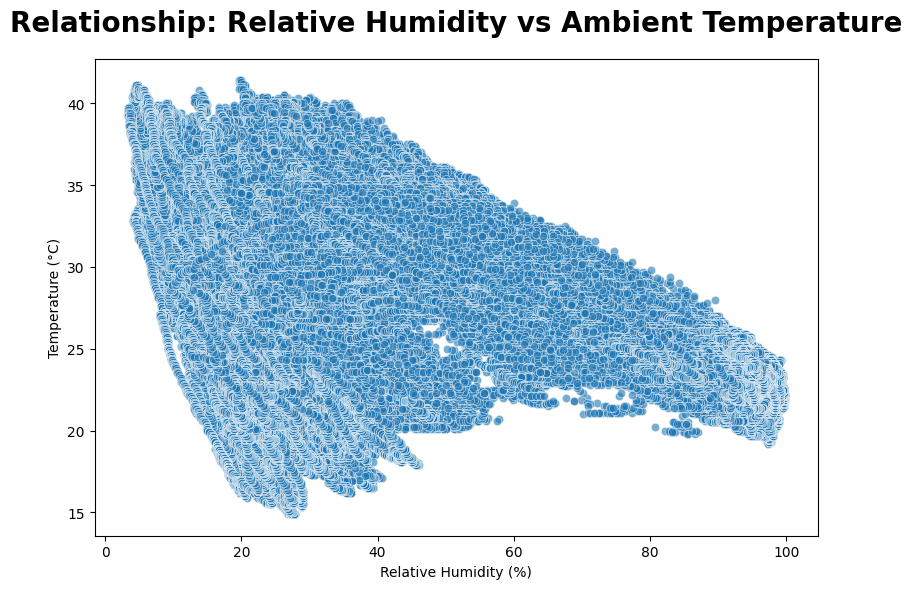

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x='RH', y='Tamb', alpha=0.6)
plt.title('Relationship: Relative Humidity vs Ambient Temperature' , fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()


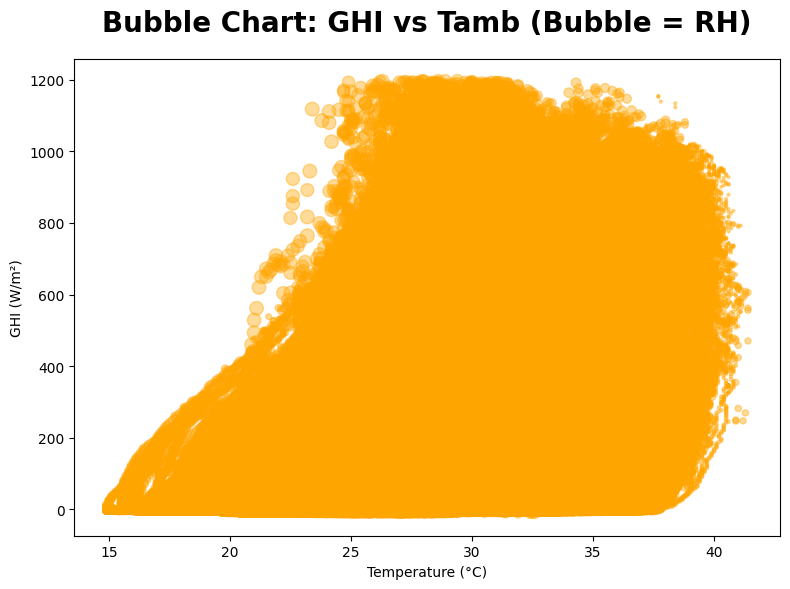

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(df_clean['Tamb'], df_clean['GHI'],
            s=df_clean['RH'], alpha=0.4, color='orange')
plt.title('Bubble Chart: GHI vs Tamb (Bubble = RH)' , fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()
